In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from datasets import load_dataset

from jobsearch.params import ARIA_70B_QUANTIZED, FT_DATASET_HF
from jobsearch.database import fetch_data_from_postgresql

MAX_CONTEXT_LEN = 4096

### Load data

In [13]:
ft_data = load_dataset(FT_DATASET_HF, split="train+test")
all_data = fetch_data_from_postgresql(columns="description", import_from_cloud=True)

Using CLOUD postgres database ...


In [14]:
descriptions = all_data.copy()

### Load tokenizer

In [4]:
tokenizer = AutoTokenizer.from_pretrained(ARIA_70B_QUANTIZED)

### Token counts

In [6]:
instructions_only = """Structure les informations de salaire en JSON en normalisant les données :
- Pour un salaire indiqué comme minimum (ex. 'à partir de 30k'), définis-le comme 'montant_min'.
- Si indiqué comme maximum (ex. 'jusqu'à 70000'), définis-le comme 'montant_max'.
- En cas de montant unique, définis-le dans 'montant_min' et 'montant_max'.
- Convertis tous les montants en format décimal y compris ceux exprimés en abréviations. Par exemple, "25k" ou "25ke" devient 25000.0.
- En cas de fourchette de salaire (ex. 'entre 40k et 55ke/an'), segmente-la dans 'montant_min' (40000.0) et 'montant_max' (55000.0) respectivement.
- 'frequence_versement' accepte des valeurs normalisées comme 'an', 'mois', 'semaine', 'jour', 'heure'.
- 'devise' accepte les symboles standards '$', '€' et '£'.
- En cas de manquement de la fréquence ou devise, suppose leur valeurs.
- Si aucun montant explicites n'est mentionné, remplis tous les champs avec la valeur null.
- Des expressions comme "Selon expérience", "A négocier", "Rémunération attractive, ect ne sont pas des montants explicites. Remplis null pour tous les champs.
- Si plusieurs salaires ou fourchettes différentes sont détaillés, liste les toutes. Chaque salaire doit pouvoir etre entierement décrite dans son dictionnaire.
- Privilégie les fourchettes détaillées aux salaire unique ou approximations. Par exemple, si une meme offre mentionne "salaire environ 35k" et ensuite "salaire entre 30 000 et 40 000", privilégie la seconde formulation.
- Assures toi que les informations extraites sont logiquement cohérentes (ex. 'montant_min' <= 'montant_max').

JSON schema : 

{
    "type" : "object",
    "properties" : {
      "salaire" : {
        "type" : "array",
        "items" : {
          "type" : "object",
          "properties" : {
            "montant_min" : {"type" : ["number", "null"]},
            "montant_max" : {"type" : ["number", "null"]},
            "devise" : {"type" : ["string", "null"]},
            "frequence_versement" : {"type" : ["string", "null"]}
          },
          "required": ["montant_min", "montant_max", "devise", "frequence_versement"]
        }
      }
    },
    "required" : ["salaire"]
  }"""

In [15]:
# token count of fine-tuning inputs
def batch_token_count(str_sequence):
    ids_list = tokenizer.batch_encode_plus(str_sequence)['input_ids']
    token_count = [len(ids) for ids in ids_list]
    return token_count

# token count of instruction
full_prompt_token_len = len(tokenizer.tokenize(ft_data['instruction'][0]))

# token count of instructions without examples  
instructions_only_token_count = len(tokenizer.tokenize(instructions_only))

# finetuning I/O token counts
outputs_token_count = batch_token_count(ft_data['output'])
inputs_token_count = batch_token_count(ft_data['input'])

# all descriptions token counts
descriptions = descriptions.dropna(axis=0)
description_list = descriptions.description.to_list()
descriptions_token_count = batch_token_count(description_list)


### prompt token len

In [16]:
print(full_prompt_token_len, instructions_only_token_count)

822 740


### Exploring descriptions token counts

In [17]:
des_token_df = pd.Series(descriptions_token_count) 
des_token_df.describe(percentiles=[.99])

count    47956.000000
mean       856.354846
std        463.594247
min          3.000000
50%        802.000000
99%       2206.350000
max      14981.000000
dtype: float64

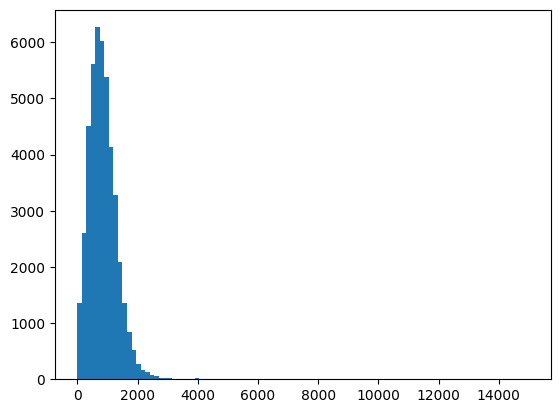

In [10]:
plt.hist(descriptions_token_count, bins=100);

In [11]:
max_description_len_full_prompt = MAX_CONTEXT_LEN - full_prompt_token_len
max_description_len_instruction_only = MAX_CONTEXT_LEN - instructions_only_token_count

print(max_description_len_full_prompt, max_description_len_instruction_only)

3274 3356


In [73]:
#pd.options.display.max_colwidth = 100
#pd.options.display.max_colwidth = 500

descriptions['token_count'] = descriptions_token_count
descriptions[descriptions['token_count'] > max_description_len_full_prompt].sort_values('token_count', ascending=False).shape

(3574, 2)

In [74]:
descriptions[descriptions['token_count'] > max_description_len_instruction_only].sort_values('token_count', ascending=False).shape

(38, 2)

### Exploring fine-tuning data outputs token's count

count    184.000000
mean      50.804348
std       16.382544
min       39.000000
25%       39.000000
50%       50.000000
75%       56.000000
80%       56.000000
90%       56.000000
95%       56.000000
99%      106.970000
max      193.000000
dtype: float64


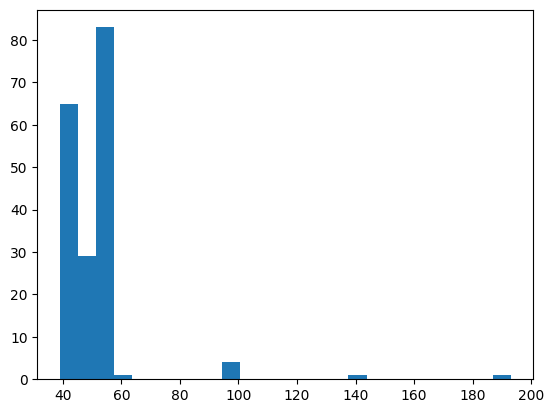

In [12]:
print(pd.Series(outputs_token_count).describe(percentiles=[.25,.5,.75,.8,.9,.95,.99]))

plt.hist(outputs_token_count, bins=25);

### Exploring ft data inputs token counts

count     184.000000
mean      901.782609
std       460.047071
min        71.000000
25%       540.750000
50%       840.500000
75%      1223.750000
80%      1299.800000
90%      1525.400000
95%      1682.600000
99%      2000.510000
max      2878.000000
dtype: float64


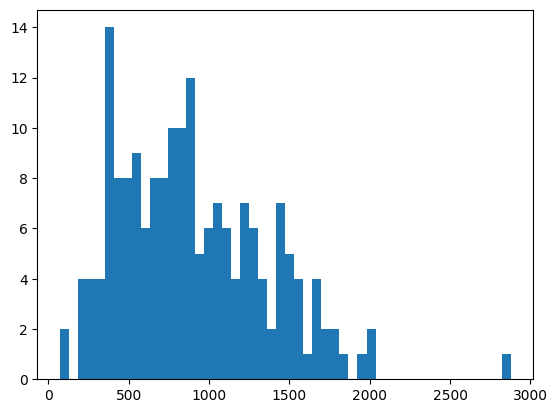

In [66]:
print(pd.Series(inputs_token_count).describe(percentiles=[.25,.5,.75,.8,.9,.95,.99]))

plt.hist(inputs_token_count, bins=50);